Organized the data in the right format

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

df_00 = pd.read_csv("dataset-of-00s.csv")
df_10 = pd.read_csv("dataset-of-10s.csv")
df_60 = pd.read_csv("dataset-of-60s.csv")
df_70 = pd.read_csv("dataset-of-70s.csv")
df_80 = pd.read_csv("dataset-of-80s.csv")
df_90 = pd.read_csv("dataset-of-90s.csv")

df = pd.concat([df_00, df_10, df_60, df_70, df_80, df_90])
df = df.drop(axis=1, labels='time_signature')
#Scaling the data
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

df_X = df.iloc[:,3:17]


df_scaled = scale.fit_transform(df_X)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = df_X.columns
df_scaled


df_clean= df_scaled
for col in df_clean.columns:
  q1=df_clean[col].quantile(0.25)
  q3=df_clean[col].quantile(0.75)
  inq=q3-q1
  filter=(df_clean[col] >= q1-1.5*inq) & (df_clean[col] <= q3+1.5*inq)
  df_clean[col] = df_clean[col].loc[filter]
#Removing outliers

df_clean = df_clean.drop(axis=1, labels=['speechiness', 'instrumentalness'])

df_remove = df_clean.dropna()
#Removing missing values
df_remove.shape
#The number of songs remaining is 33401
df_merge = df.iloc[df_remove.index]
df_merge = df_merge.drop(axis=1, labels=['speechiness', 'instrumentalness'])
df_merge.columns
#Removed the predictors that were not used from the original dataset

#observations in each class
df_merge.groupby('target')[['danceability', 'energy', 'key', 'loudness',
       'mode', 'acousticness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'chorus_hit', 'sections']].count()


df_merge.iloc[:,3:15]
#creating final scaled data with all the variables
scale = StandardScaler()
scale_X = scale.fit_transform(df_merge.iloc[:,3:15])
df_merge.iloc[:,3:15] = scale_X

X = df_merge.iloc[:,3:15]
X.shape

y = df_merge['target']
y.shape

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=1)
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train_final, X_valid, y_train_final, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
#print(X_train_final)

In [6]:
# Convert pandas DataFrame to NumPy arrays if they aren't already
X_train_final_np = X_train_final.to_numpy()
X_valid_np = X_valid.to_numpy()
y_train_final_np = y_train_final.to_numpy()
y_valid_np = y_valid.to_numpy()


k=1: Accuracy=0.6481, Time=15.67 seconds
k=2: Accuracy=0.6481, Time=15.39 seconds
k=3: Accuracy=0.6693, Time=14.11 seconds
k=4: Accuracy=0.6751, Time=14.14 seconds
k=5: Accuracy=0.6855, Time=14.24 seconds
k=6: Accuracy=0.6886, Time=14.24 seconds
k=7: Accuracy=0.6967, Time=14.67 seconds
k=8: Accuracy=0.7000, Time=14.25 seconds
k=9: Accuracy=0.6991, Time=14.28 seconds
k=10: Accuracy=0.6963, Time=14.46 seconds
k=11: Accuracy=0.7000, Time=14.37 seconds
k=12: Accuracy=0.7016, Time=14.29 seconds
k=13: Accuracy=0.7015, Time=14.27 seconds
k=14: Accuracy=0.7055, Time=14.36 seconds
k=15: Accuracy=0.7031, Time=14.27 seconds
k=16: Accuracy=0.7057, Time=14.29 seconds
k=17: Accuracy=0.7040, Time=14.19 seconds
k=18: Accuracy=0.7073, Time=14.22 seconds
k=19: Accuracy=0.7099, Time=14.15 seconds
k=20: Accuracy=0.7081, Time=14.36 seconds
k=21: Accuracy=0.7096, Time=14.23 seconds
k=22: Accuracy=0.7115, Time=14.18 seconds
k=23: Accuracy=0.7096, Time=14.32 seconds
k=24: Accuracy=0.7093, Time=14.88 seconds
k

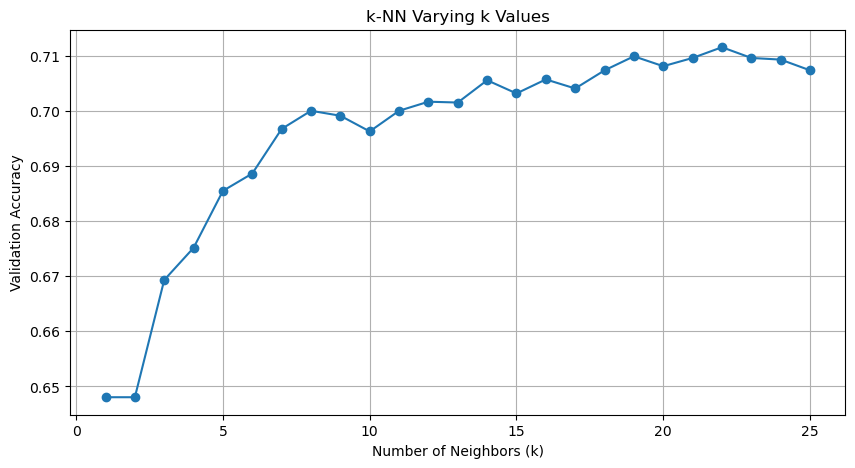

In [9]:
import matplotlib.pyplot as plt
import time

class KNearestNeighbors:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predicted_labels = [self._predict(x) for x in X]
        return np.array(predicted_labels)

    def _predict(self, x):
        # Compute the distances between x and all examples in the training set
        distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
        # Sort by distance and return indices of the first k neighbors
        k_indices = np.argsort(distances)[:self.k]
        # Extract the labels of the k nearest neighbors
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        # Return the most common class label
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

def plot_knn_accuracies(X_train, y_train, X_valid, y_valid, max_k=10):
    accuracies = []
    times = []
    k_values = range(1, max_k + 1)
    
    for k in k_values:
        start_time = time.time()
        knn = KNearestNeighbors(k=k)
        knn.fit(X_train, y_train)
        predictions = knn.predict(X_valid)
        accuracy = np.sum(predictions == y_valid) / len(y_valid)
        end_time = time.time()
        
        accuracies.append(accuracy)
        times.append(end_time - start_time)
        print(f"k={k}: Accuracy={accuracy:.4f}, Time={end_time - start_time:.2f} seconds")

    plt.figure(figsize=(10, 5))
    plt.plot(k_values, accuracies, marker='o')
    plt.title('k-NN Varying k Values')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Validation Accuracy')
    plt.grid(True)
    plt.show()

    return accuracies, times

# Use the function
accuracies, times = plot_knn_accuracies(X_train_final_np, y_train_final_np, X_valid_np, y_valid_np, max_k=25)


In [8]:
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

def evaluate_knn_test_data(X_train, y_train, X_test, y_test, optimal_k):
    # Initialize the k-NN classifier with the optimal k value
    knn = KNearestNeighbors(k=optimal_k)
    
    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    # Predict on the test set
    y_test_pred = knn.predict(X_test)
    
    # Calculate the accuracy on the test set
    test_accuracy = np.sum(y_test_pred == y_test) / len(y_test)
    
    # Print the results
    print(f"Test Accuracy with k={optimal_k}: {test_accuracy:.4f}")

# Assuming X_test_np and y_test_np are the test data converted to NumPy arrays
evaluate_knn_test_data(X_train_final_np, y_train_final_np, X_test_np, y_test_np, optimal_k=8)

Test Accuracy with k=8: 0.6878


Validation Accuracy (scikit-learn): 0.6692


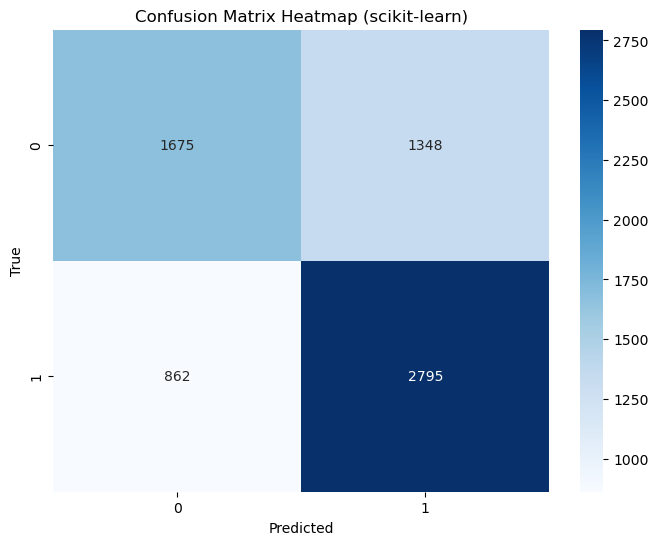

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create a k-NN classifier instance with k neighbors
knn_sklearn = KNeighborsClassifier(n_neighbors=3)

# Fit the classifier to the training data
knn_sklearn.fit(X_train_final, y_train_final)

# Predict on the validation set
y_valid_pred_sklearn = knn_sklearn.predict(X_valid)

# Calculate the accuracy on the validation set using scikit-learn's accuracy_score function
accuracy_sklearn = accuracy_score(y_valid, y_valid_pred_sklearn)
print(f"Validation Accuracy (scikit-learn): {accuracy_sklearn:.4f}")

# Calculate the confusion matrix using scikit-learn's confusion_matrix function
conf_matrix_sklearn = confusion_matrix(y_valid, y_valid_pred_sklearn)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_sklearn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap (scikit-learn)')
plt.show()
